In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datetime import datetime
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import pdb

In [ ]:
import keras
from keras.layers import LSTM, Dense, TimeDistributed, Input, Embedding, GRU, Activation, Dropout, RepeatVector
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError

### Fine tune LR

In [ ]:
# manually inspect validation losses and choose the best LR
def tune_lr(model_type:str, lr_list:list, Xtr, ytr, Xval, yval)->None:
  for i in lr_list:
    if model_type == 'gru':
      model = build_gru(IN_DIM, OUT_DIM, lr=i)
    elif model_type == 'lstm_ae':
      model = build_lstm_autoencoder(IN_DIM, OUT_DIM, lr=i)

    print("{}, lr={}".format(model_type, i))
    fit(model, Xtr, ytr, Xval, yval)

### Import Datasets

In [ ]:
data_path = '/content/drive/MyDrive/STATS307/Data/'

X_all = pd.read_csv(data_path + 'changeinvisitors.csv')
cases_all_df = pd.read_csv(data_path + 'covid19_confirmed_US.csv') # For all counties, not aggregated

### US-AGG Data

In [ ]:
X = X_all.copy(deep=True)
Y = cases_all_df.copy(deep=True)
Y.iloc[:,11:] = Y.iloc[:, 11:].diff(axis=1)
Y = Y.sum(axis=0).reset_index().rename(columns={'index':'date', 0:'cases'}).loc[11:]
Y['cases'] = np.log(Y['cases'].astype(float)).replace(-np.inf, 0)

<ipython-input-155-b28ecb061bac>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.sum(axis=0).reset_index().rename(columns={'index':'date', 0:'cases'}).loc[11:]
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
X['Day'] = pd.to_datetime(X['Day'])
X.rename(columns={'Day':'date'},inplace=True)
Y['date'] = pd.to_datetime(Y['date'])

In [ ]:
X.columns, Y.columns

(Index(['Entity', 'Code', 'date', 'retail_and_recreation',
        'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
        'workplaces'],
       dtype='object'), Index(['date', 'cases'], dtype='object'))

In [ ]:
X = X.loc[~X.isna().any(axis=1)]
X.drop(labels=['Code', 'Entity'], axis=1, inplace=True)
X.columns

Index(['date', 'retail_and_recreation', 'grocery_and_pharmacy', 'residential',
       'transit_stations', 'parks', 'workplaces'],
      dtype='object')

In [ ]:
# Normalize
X.iloc[:,1:] = (X.iloc[:,1:]-X.iloc[:,1:].mean()) / X.iloc[:,1:].std()

In [ ]:
avail_dates = set(X['date']).intersection(set(Y['date']))
X = X[X['date'].isin(avail_dates)]
Y = Y[Y['date'].isin(avail_dates)]
len(avail_dates)

972

In [ ]:
X['dayofweek'] = X['date'].dt.dayofweek
X['month'] = X['date'].dt.month
X['year'] = X['date'].dt.year
X['year_mod'] = (X['year'] - X['year'].min()) / (X['year'].max() - X['year'].min())
X.drop(['year'], axis=1, inplace=True)

In [ ]:
X.shape, Y.shape, X.isna().any(),Y.isna().any()

((972, 10), (972, 2), date                     False
 retail_and_recreation    False
 grocery_and_pharmacy     False
 residential              False
 transit_stations         False
 parks                    False
 workplaces               False
 dayofweek                False
 month                    False
 year_mod                 False
 dtype: bool, date     False
 cases    False
 dtype: bool)

In [ ]:
def X_Y_window(X, Y, window_size=340):
  X_window, y_window = [], []
  date_len = X.shape[0]
  for i in range(date_len - window_size):
    X_window.append(X[i:i+window_size])
    y_window.append(Y.iloc[i+window_size-1])

  return np.array(X_window), np.array(y_window)

In [ ]:
TRAIN_START = X[X['date'] == datetime(2020,5,19)].index[0]
TRAIN_END = X[X['date'] == datetime(2021,5,18)].index[0]
VAL_START = X[X['date'] == datetime(2020,6,2)].index[0]
VAL_END = X[X['date'] == datetime(2021,6,1)].index[0]
TEST_START = X[X['date'] == datetime(2020,6,16)].index[0]
TEST_END = X[X['date'] == datetime(2021,6,15)].index[0]

In [ ]:
Xtr_agg, Ytr_agg = X_Y_window(X.iloc[TRAIN_START:TRAIN_END, 1:], Y.iloc[TRAIN_START:TRAIN_END, 1], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_agg, Yval_agg = X_Y_window(X.iloc[VAL_START:VAL_END, 1:], Y.iloc[VAL_START:VAL_END, 1], window_size=350)
Xtest_agg, Ytest_agg = X_Y_window(X.iloc[TEST_START:TEST_END, 1:], Y.iloc[TEST_START:TEST_END, 1], window_size=350)

In [ ]:
Xtr_agg.shape, Ytr_agg.shape, Xval_agg.shape, Yval_agg.shape, Xtest_agg.shape, Ytest_agg.shape

((14, 350, 9), (14,), (14, 350, 9), (14,), (14, 350, 9), (14,))

### US-AGG Models

In [ ]:
IN_DIM, OUT_DIM = (Xtr_agg.shape[1], Xtr_agg.shape[2]), 1
print(IN_DIM, OUT_DIM)

(350, 9) 1


In [ ]:
def build_gru_1(in_dim, out_dim, lr=1e-2):
  model = Sequential()
  model.add(GRU(64, input_shape=in_dim, dropout=0.3, activation="relu"))
  model.add(Dense(8, 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(out_dim, 'linear'))
  model.compile(loss="mse", optimizer=Adam(learning_rate=lr))#, metrics=[MeanSquaredError()])
  model.summary()
  return model

def build_gru_2(in_dim, out_dim, lr=1e-2):
  model = Sequential()
  model.add(GRU(128, input_shape=in_dim, dropout=0.3, activation="relu", return_sequences=True))
  model.add(GRU(64, input_shape=in_dim, dropout=0.1, activation="relu"))
  model.add(Dense(8, 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(out_dim, 'linear'))
  model.compile(loss="mse", optimizer=Adam(learning_rate=lr))#, metrics=[MeanSquaredError()])
  model.summary()
  return model

def build_gru_3(in_dim, out_dim, lr=1e-3):
  model = Sequential()
  model.add(GRU(256, input_shape=in_dim, dropout=0.3, activation="relu", return_sequences=True))
  model.add(GRU(128, input_shape=in_dim, dropout=0.3, activation="relu", return_sequences=True))
  model.add(GRU(64, input_shape=in_dim, dropout=0.1, activation="relu"))
  model.add(Dense(8, 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(out_dim, 'linear'))
  model.compile(loss="mse", optimizer=Adam(learning_rate=lr))#, metrics=[MeanSquaredError()])
  model.summary()
  return model

def fit(model, Xtr, ytr, Xval, yval, epoch=50):
  hist = model.fit(Xtr, ytr, validation_data=(Xval, yval), epochs=epoch, batch_size=10, verbose=1)
  return model, hist

def predict(model, Xtest, ytest):
  predictions = model.predict(Xtest).squeeze()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':ytest})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  return df, mse(ytest, predictions)

### GRU-1

In [ ]:
gru1_agg, hist = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_agg, Ytr_agg, Xval_agg, Yval_agg, epoch=300)

GRU-1: Train/Val Analysis

0.3090643584728241 0.15021537244319916


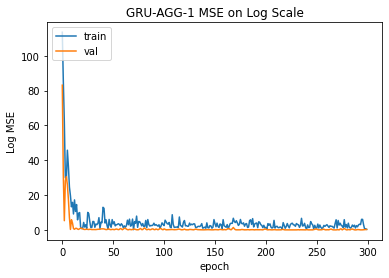

In [ ]:
print(min(hist.history['loss']), min(hist.history['val_loss']))
plt.plot(hist.history['loss'])#[:100])
plt.plot(hist.history['val_loss'])#[:100])
plt.title('GRU-AGG-1 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Val <<< Train: Underfitting?

1/1 [==============================] - 0s 165ms/step
gru1_agg: MSE:0.2846561571917556


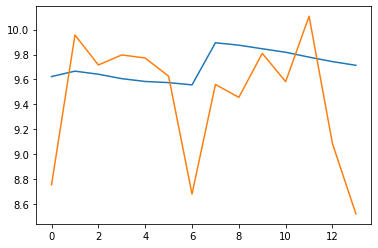

In [ ]:
gru1_agg_pred, gru1_agg_mse = predict(gru1_agg, Xtest_agg, Ytest_agg)
print('gru1_agg: MSE:{}'.format(gru1_agg_mse))

Text(0.5, 1.0, 'Actual Cases + Predicted Cases')

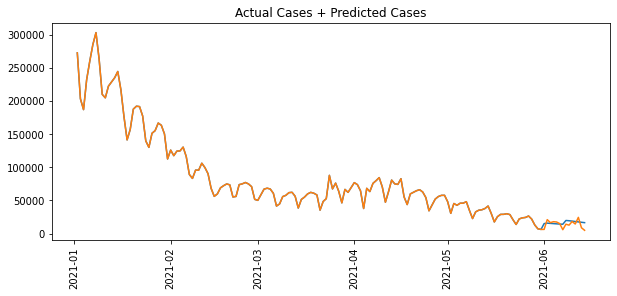

In [ ]:
figure(figsize=(10, 4))
plt_dates = Y.iloc[TEST_START+200:TEST_END, 0]
plt_yhist_pred = np.exp(list(Y.iloc[TEST_START+200:TEST_END-len(Ytest_agg), 1]) + list(gru1_agg_pred['Predictions']))
plt_yhist_act = np.exp(list(Y.iloc[TEST_START+200:TEST_END-len(Ytest_agg), 1]) + list(gru1_agg_pred['Actuals']))
plt.plot(plt_dates, plt_yhist_pred)
plt.plot(plt_dates, plt_yhist_act)
plt.xticks(rotation=90)
plt.title('Actual Cases + Predicted Cases')

In [ ]:
### From Best SARIMA results
arima_pred = [9.458088753878101,9.537782382533914, 9.641969250718859, 9.80703311526756, 9.670979023412055,\
              9.29576349196867, 8.846586048431215, 9.271018422981124, 9.585086822391508, 9.81215251592152,\
              9.732643375138142, 9.504667966580822, 9.170717976403866, 9.072170995873112]

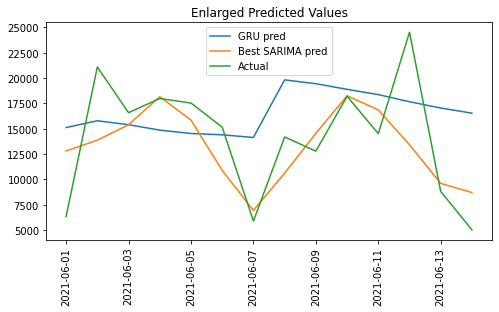

In [ ]:
figure(figsize=(8, 4))
plt_dates = Y.iloc[TEST_END-14:TEST_END, 0]
plt_yhist_pred = np.exp(list(gru1_agg_pred['Predictions']))
plt_yhist_pred_ar = np.exp(arima_pred)
plt_yhist_act = np.exp(list(gru1_agg_pred['Actuals']))
plt.plot(plt_dates, plt_yhist_pred, label='GRU pred')
plt.plot(plt_dates, plt_yhist_pred_ar, label='Best SARIMA pred')
plt.plot(plt_dates, plt_yhist_act, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.title('Enlarged Predicted Values')
plt.savefig('pred-comp-enlarged.png')

### GRU-2

In [ ]:
gru2_agg, hist2 = fit(build_gru_2(IN_DIM, OUT_DIM), Xtr_agg, Ytr_agg, Xval_agg, Yval_agg, epoch=300)

GRU-2: Train/Val Analysis

0.1387409120798111 0.12067638337612152


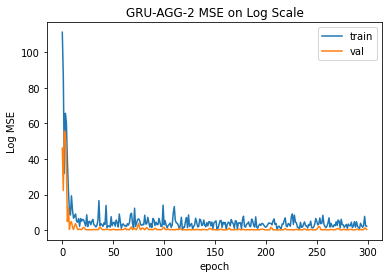

In [ ]:
print(min(hist2.history['loss']), min(hist2.history['val_loss']))
plt.plot(hist2.history['loss'][0:])
plt.plot(hist2.history['val_loss'][0:])
plt.title('GRU-AGG-2 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 62ms/step
gru2_agg: MSE:1.6256284366299631


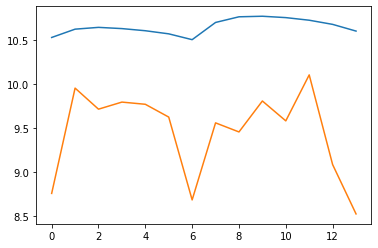

In [ ]:
gru2_agg_pred, gru2_agg_mse = predict(gru2_agg, Xtest_agg, Ytest_agg)
print('gru2_agg: MSE:{}'.format(gru2_agg_mse))

In [ ]:
figure(figsize=(10, 4))
plt_dates = Y.iloc[TEST_START+200:TEST_END, 0]
plt_yhist_pred = np.exp(list(Y.iloc[TEST_START+200:TEST_END-len(Ytest_agg), 1]) + list(gru2_agg_pred['Predictions']))
plt_yhist_act = np.exp(list(Y.iloc[TEST_START+200:TEST_END-len(Ytest_agg), 1]) + list(gru2_agg_pred['Actuals']))
plt.plot(plt_dates, plt_yhist_pred)
plt.plot(plt_dates, plt_yhist_act)
plt.xticks(rotation=90)
plt.title('Actual Cases + Predicted Cases')

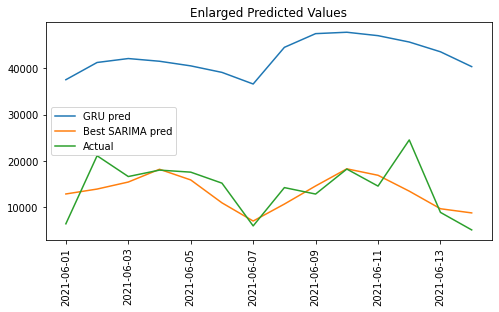

In [ ]:
figure(figsize=(8, 4))
plt_dates = Y.iloc[TEST_END-14:TEST_END, 0]
plt_yhist_pred = np.exp(list(gru2_agg_pred['Predictions']))
plt_yhist_pred_ar = np.exp(arima_pred)
plt_yhist_act = np.exp(list(gru2_agg_pred['Actuals']))
plt.plot(plt_dates, plt_yhist_pred, label='GRU pred')
plt.plot(plt_dates, plt_yhist_pred_ar, label='Best SARIMA pred')
plt.plot(plt_dates, plt_yhist_act, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.title('Enlarged Predicted Values')
plt.savefig('pred-comp-enlarged.png')

Compare to ARIMA/SARIMA preds

In [ ]:
figure(figsize=(12, 8))

plt_dates = Y.iloc[TEST_START:TEST_END, 0]
plt_yhist_pred = np.exp(list(Y.iloc[TEST_START:TEST_END-len(Ytest_agg), 1]) + list(gruAGG_pred['Predictions']))
plt_yhist_pred_ar = np.exp(list(Y.iloc[TEST_START:TEST_END-len(Ytest_agg), 1]) + arima_pred)
plt_yhist_act = np.exp(list(Y.iloc[TEST_START:TEST_END-len(Ytest_agg), 1]) + list(gruAGG_pred['Actuals']))

plt.plot(plt_dates, plt_yhist_pred, label='GRU pred',linewidth=.5)
plt.plot(plt_dates, plt_yhist_pred_ar, label='Best SARIMA pred',linewidth=.5)
plt.plot(plt_dates, plt_yhist_act, label='Actual',linewidth=.5)
plt.xticks(rotation=90)
plt.legend()
plt.axvspan(datetime(2021,6,1), datetime(2021,6,15), color='gray', alpha=0.2)
plt.title('Actual and Predicted (highlighted) Confirmed Cases, June 2020 to June 2021')
plt.savefig('pred-comp.png')

### GRU-3

In [ ]:
gru3_agg, hist3 = fit(build_gru_3(IN_DIM, OUT_DIM), Xtr_agg, Ytr_agg, Xval_agg, Yval_agg, epoch=300)

GRU-3: Train/Val Analysis

0.11039098352193832 0.17102019488811493


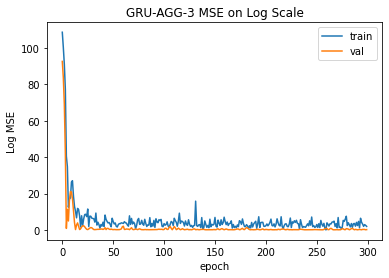

In [ ]:
print(min(hist3.history['loss']), min(hist3.history['val_loss']))
plt.plot(hist3.history['loss'][0:])
plt.plot(hist3.history['val_loss'][0:])
plt.title('GRU-AGG-3 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

1/1 [==============================] - 1s 544ms/step
gru3_agg: MSE:0.45559217599934143


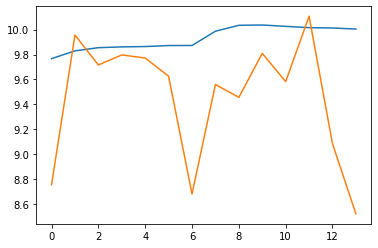

In [ ]:
gru3_agg_pred, gru3_agg_mse = predict(gru3_agg, Xtest_agg, Ytest_agg)
print('gru3_agg: MSE:{}'.format(gru3_agg_mse))

Text(0.5, 1.0, 'Actual Cases + Predicted Cases')

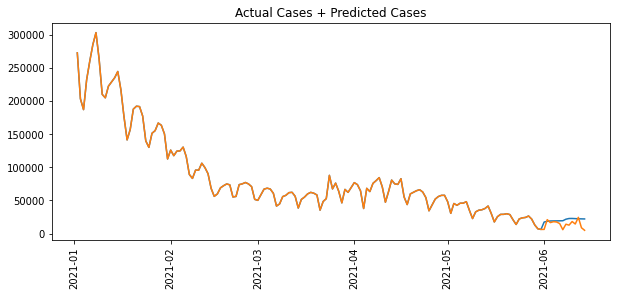

In [ ]:
figure(figsize=(10, 4))
plt_dates = Y.iloc[TEST_START+200:TEST_END, 0]
plt_yhist_pred = np.exp(list(Y.iloc[TEST_START+200:TEST_END-len(Ytest_agg), 1]) + list(gru3_agg_pred['Predictions']))
plt_yhist_act = np.exp(list(Y.iloc[TEST_START+200:TEST_END-len(Ytest_agg), 1]) + list(gru3_agg_pred['Actuals']))
plt.plot(plt_dates, plt_yhist_pred)
plt.plot(plt_dates, plt_yhist_act)
plt.xticks(rotation=90)
plt.title('Actual Cases + Predicted Cases')

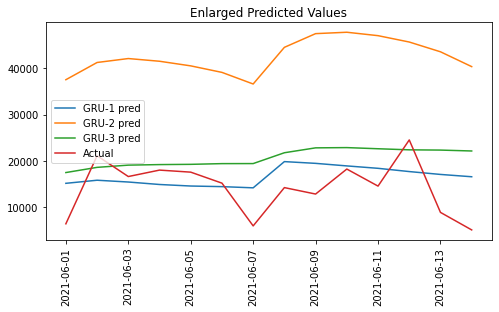

In [ ]:
figure(figsize=(8, 4))
plt_dates = Y.iloc[TEST_END-14:TEST_END, 0]

plt_yhist_pred1 = np.exp(list(gru1_agg_pred['Predictions']))
plt_yhist_pred2 = np.exp(list(gru2_agg_pred['Predictions']))
plt_yhist_pred3 = np.exp(list(gru3_agg_pred['Predictions']))
plt_yhist_pred_ar = np.exp(arima_pred)
plt_yhist_act = np.exp(list(gru3_agg_pred['Actuals']))

plt.plot(plt_dates, plt_yhist_pred1, label='GRU-1 pred')
plt.plot(plt_dates, plt_yhist_pred2, label='GRU-2 pred')
plt.plot(plt_dates, plt_yhist_pred3, label='GRU-3 pred')

plt.plot(plt_dates, plt_yhist_act, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.title('Enlarged Predicted Values')
plt.savefig('pred-comp-enlarged.png')

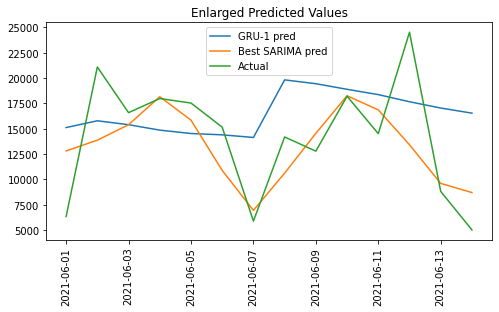

In [ ]:
figure(figsize=(8, 4))
plt_dates = Y.iloc[TEST_END-14:TEST_END, 0]

plt_yhist_pred1 = np.exp(list(gru1_agg_pred['Predictions']))
plt_yhist_pred_ar = np.exp(arima_pred)
plt_yhist_act = np.exp(list(gru3_agg_pred['Actuals']))

plt.plot(plt_dates, plt_yhist_pred1, label='GRU-1 pred')
plt.plot(plt_dates, plt_yhist_pred_ar, label='Best SARIMA pred')
plt.plot(plt_dates, plt_yhist_act, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.title('Enlarged Predicted Values')
plt.savefig('pred-comp-enlarged.png')

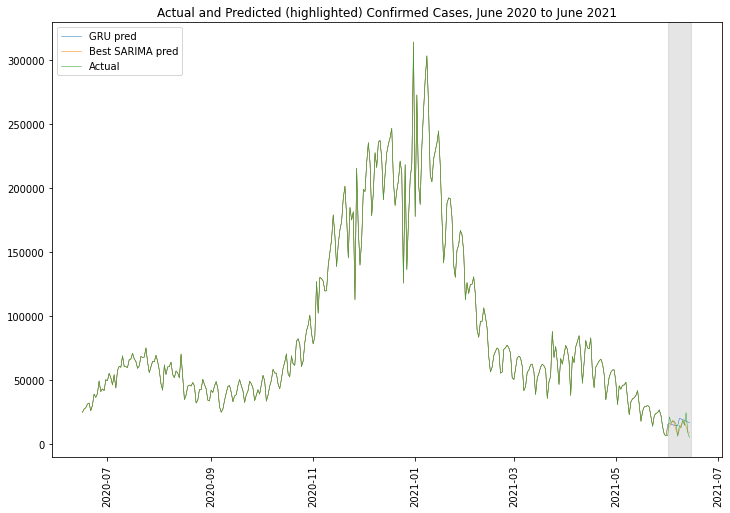

In [ ]:
figure(figsize=(12, 8))

plt_dates = Y.iloc[TEST_START:TEST_END, 0]
plt_yhist_pred = np.exp(list(Y.iloc[TEST_START:TEST_END-len(Ytest_agg), 1]) + list(gru1_agg_pred['Predictions']))
plt_yhist_pred_ar = np.exp(list(Y.iloc[TEST_START:TEST_END-len(Ytest_agg), 1]) + arima_pred)
plt_yhist_act = np.exp(list(Y.iloc[TEST_START:TEST_END-len(Ytest_agg), 1]) + list(gru1_agg_pred['Actuals']))

plt.plot(plt_dates, plt_yhist_pred, label='GRU pred',linewidth=.5)
plt.plot(plt_dates, plt_yhist_pred_ar, label='Best SARIMA pred',linewidth=.5)
plt.plot(plt_dates, plt_yhist_act, label='Actual',linewidth=.5)
plt.xticks(rotation=90)
plt.legend()
plt.axvspan(datetime(2021,6,1), datetime(2021,6,15), color='gray', alpha=0.2)
plt.title('Actual and Predicted (highlighted) Confirmed Cases, June 2020 to June 2021')
plt.savefig('pred-comp.png')

### US - counties: Import Datasets

In [ ]:
cases_df = pd.read_csv(data_path + 'covid-us-filtered.csv') # Filtered for counties
mobility_df = pd.read_csv(data_path + 'mobilitycountymice.csv')

In [ ]:
cases_df.iloc[:,4:] = cases_df.iloc[:, 4:].diff(axis=1)
cases_df = cases_df[cases_df['State'].isin(['California', 'New York', 'Florida'])]

#### Mobility: 

In [ ]:
print(mobility_df.shape)
mobility_df = mobility_df[mobility_df['sub_region_1'].isin(['California', 'New York', 'Florida'])]
print(mobility_df.shape)

(9730, 11)
(5844, 11)


In [ ]:
mobility_df.drop(['country_region_code', 'country_region'], axis=1, inplace=True)
mobility_df['county-state'] = mobility_df['sub_region_2'].apply(lambda x: x[:-7]) + ', ' + mobility_df['sub_region_1'] + ', US'
mobility_df.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_and_recreation',\
                    'grocery_and_pharmacy_percent_change_from_baseline':'grocery_and_pharmacy',\
                    'parks_percent_change_from_baseline':'parks',\
                    'transit_stations_percent_change_from_baseline':'transit_stations',\
                    'workplaces_percent_change_from_baseline':'workplaces',\
                    'residential_percent_change_from_baseline':'residential'}, inplace=True)
mobility_df['date'] = pd.to_datetime(mobility_df['date'])

Some dates aren't availble for some counties - get avail. dates in all places

In [ ]:
locs = mobility_df['county-state'].unique()
dates = []
for key in locs:
  dates.append(set(mobility_df[mobility_df['county-state']==key]['date']))

dates = sorted(list(set.intersection(*dates)))
print(len(dates), 'out of', cases_df.shape[1]-4)

974 out of 1026


In [ ]:
from datetime import datetime
print('before: {}'.format(mobility_df.shape))
start, end = dates.index(datetime(2020, 5, 19)), dates.index(datetime(2021, 6, 15)) 
mobility_df = mobility_df[mobility_df['date'].isin(dates[start-1: ])] #TRAIN_START-1 to adjust for .diff()
print('after: {}'.format(mobility_df.shape))

before: (5844, 10)
after: (5286, 10)


Difference & Drop 1st row (date).
Normalize each feature.

In [ ]:
locs = mobility_df['county-state'].unique()
X_dict = {key: None for key in locs}

for key, _ in X_dict.items():
  X_dict[key] = mobility_df[mobility_df['county-state']==key]

  # Difference
  X_dict[key].iloc[:,3:-1] = X_dict[key].iloc[:,3:-1].diff(axis=0)
  X_dict[key] = X_dict[key].iloc[1:]
  X_dict[key].drop(['sub_region_1', 'sub_region_2', 'county-state'], axis=1, inplace=True)
  # Normalize
  X_dict[key].iloc[:, 1:]=(X_dict[key].iloc[:, 1:]-X_dict[key].iloc[:, 1:].mean())/X_dict[key].iloc[:, 1:].std()
  
  X_dict[key]['dayofweek'] = X_dict[key]['date'].dt.dayofweek
  X_dict[key]['month'] = X_dict[key]['date'].dt.month
  X_dict[key]['year'] = X_dict[key]['date'].dt.year
  X_dict[key]['year_mod'] = (X_dict[key]['year'] - X_dict[key]['year'].min()) / (X_dict[key]['year'].max() - X_dict[key]['year'].min())
  # Remove unnecessary columns
  X_dict[key].drop(['year'], axis=1, inplace=True)
  X_dict[key].reset_index(inplace=True)
  X_dict[key].drop('index', axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [ ]:
TRAIN_START = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2020, 5, 19)].index[0]
TRAIN_END = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2021, 5, 18)].index[0] # Exclude this end
VAL_START = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2020, 6, 2)].index[0] 
VAL_END = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2021, 6, 1)].index[0] 
TEST_START = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2020, 6, 16)].index[0] 
TEST_END = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2021, 6, 15)].index[0]+1

In [ ]:
for key in X_dict.keys():
  X_dict[key] = X_dict[key].iloc[TRAIN_START:TEST_END]

In [ ]:
X = np.dstack([v.iloc[:,1:] for v in X_dict.values()])
X.shape

(393, 9, 6)

#### Y: Cases

Y: Filter by available dates. Rename columns.

In [ ]:
cases_df

,County,State,Country_Region,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/3/22,11/4/22,11/5/22,11/6/22,11/7/22,11/8/22,11/9/22,11/10/22,11/11/22,11/12/22
0,Los Angeles,California,US,"Los Angeles, California, US",NaN,0,0,0,1,0,...,1224,1434,0,0,2958,1475,2669,0,0,0
1,Santa Barbara,California,US,"Santa Barbara, California, US",NaN,0,0,0,0,0,...,0,0,0,0,0,164,0,2,1,0
2,Highlands,Florida,US,"Highlands, Florida, US",NaN,0,0,0,0,0,...,0,100,0,0,0,0,0,0,0,0
3,Miami-Dade,Florida,US,"Miami-Dade, Florida, US",NaN,0,0,0,0,0,...,0,4109,0,0,0,0,0,0,0,0
8,New York,New York,US,"New York, New York, US",NaN,0,0,0,0,0,...,469,524,496,455,309,291,511,0,0,1344
9,Orange,New York,US,"Orange, New York, US",NaN,0,0,0,0,0,...,259,0,0,0,0,0,646,101,0,0


In [ ]:
Y_TRAIN_START = list(cases_df.columns).index('5/19/20')
Y_TRAIN_END = list(cases_df.columns).index('5/18/21')
Y_VAL_START = list(cases_df.columns).index('6/2/20')
Y_VAL_END = list(cases_df.columns).index('6/1/21')
Y_TEST_START = list(cases_df.columns).index('6/16/20')
Y_TEST_END = list(cases_df.columns).index('6/15/21')

In [ ]:
Y = cases_df.iloc[:, Y_TRAIN_START:Y_TEST_END+1].T.reset_index()
Y['index'] = pd.to_datetime(Y['index'])
Y = Y[Y['index'].isin(dates)]
Y.iloc[:,1:] = np.log(Y.iloc[:,1:].astype(float)).replace(-np.inf, 0)
Y.iloc[:,1:] = Y.iloc[:,1:].replace(np.nan, 0)
Y.rename(columns={'index':'date'}, inplace=True)
date_index = Y['date']

Y.head()

,date,0,1,2,3,8,9
0,2020-05-19,7.016610,2.995732,1.098612,4.356709,3.988984,3.135494
1,2020-05-20,7.186901,1.098612,0.000000,4.521789,3.931826,4.007333
2,2020-05-21,7.040536,2.833213,1.098612,5.808142,4.890349,3.891820
3,2020-05-22,6.940222,2.564949,0.000000,5.043425,5.117994,3.912023
4,2020-05-23,6.957497,2.484907,0.000000,5.147494,5.111988,4.007333


In [ ]:
# Change column order in Y
cols = Y.columns
cols = [cols[1], cols[5], cols[4], cols[2], cols[6], cols[3]]
Y = Y[cols]

In [ ]:
X.shape, Y.shape

((393, 9, 6), (393, 6))

### County-Lvl: Models

In [ ]:
TRAIN_START = date_index[date_index == datetime(2020,5,19)].index[0]
TRAIN_END = date_index[date_index == datetime(2021,5,18)].index[0]
VAL_START = date_index[date_index == datetime(2020,6,2)].index[0]
VAL_END = date_index[date_index == datetime(2021,6,1)].index[0]
TEST_START = date_index[date_index == datetime(2020,6,16)].index[0]
TEST_END = date_index[date_index == datetime(2021,6,15)].index[0]
TRAIN_START, TEST_END

(0, 392)

#### LA

In [ ]:
Xtr_la, Ytr_la = X_Y_window(pd.DataFrame(X[TRAIN_START:TRAIN_END, :, 0]), Y.iloc[TRAIN_START:TRAIN_END, 0], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_la, Yval_la = X_Y_window(pd.DataFrame(X[VAL_START:VAL_END, :, 0]), Y.iloc[VAL_START:VAL_END, 0], window_size=350)
Xtest_la, Ytest_la = X_Y_window(pd.DataFrame(X[TEST_START:TEST_END, :, 0]), Y.iloc[TEST_START:TEST_END, 0], window_size=350)

In [ ]:
IN_DIM, OUT_DIM = (Xtr_la.shape[1], Xtr_la.shape[2]), 1
print(IN_DIM, OUT_DIM)

(350, 9) 1


In [ ]:
gru1_la, hist1_la = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_la, Ytr_la, Xval_la, Yval_la, epoch=20)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 64)                14400     
                                                                 
 dense_38 (Dense)            (None, 8)                 520       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 14,929
Trainable params: 14,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 3s 363ms/step - loss: 36.5412 - val_loss: 23.1565
Epoch 2/20
2/2 [==============================] - 0s 134ms/step - loss: 21.5773 -

1/1 [==============================] - 0s 211ms/step
gru1_la: MSE:0.8825409415828389


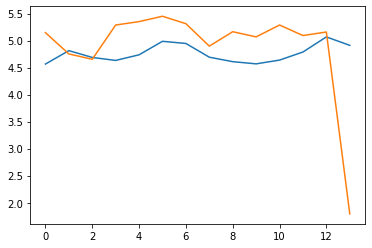

In [ ]:
gru1_la_pred, gru1_la_mse = predict(gru1_la, Xtest_la, Ytest_la)
print('gru1_la: MSE:{}'.format(gru1_la_mse))

1.7811232805252075 0.7170295715332031


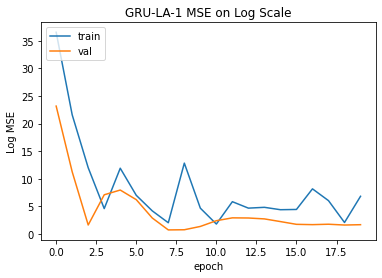

In [ ]:
print(min(hist1_la.history['loss']), min(hist1_la.history['val_loss']))
plt.plot(hist1_la.history['loss'])#[:100])
plt.plot(hist1_la.history['val_loss'])#[:100])
plt.title('GRU-LA-1 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### NY

In [ ]:
Xtr_ny, Ytr_ny = X_Y_window(pd.DataFrame(X[TRAIN_START:TRAIN_END, :, 1]), Y.iloc[TRAIN_START:TRAIN_END, 1], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_ny, Yval_ny = X_Y_window(pd.DataFrame(X[VAL_START:VAL_END, :, 1]), Y.iloc[VAL_START:VAL_END, 1], window_size=350)
Xtest_ny, Ytest_ny = X_Y_window(pd.DataFrame(X[TEST_START:TEST_END, :, 1]), Y.iloc[TEST_START:TEST_END, 1], window_size=350)

In [ ]:
gru1_ny, hist1_ny = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_ny, Ytr_ny, Xval_ny, Yval_ny, epoch=100)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 64)                14400     
                                                                 
 dense_40 (Dense)            (None, 8)                 520       
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
Total params: 14,929
Trainable params: 14,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 2s 344ms/step - loss: 28.4532 - val_loss: 14.3919
Epoch 2/100
2/2 [==============================] - 0s 128ms/step - loss: 18.8203

0.21655689179897308 0.08397505432367325


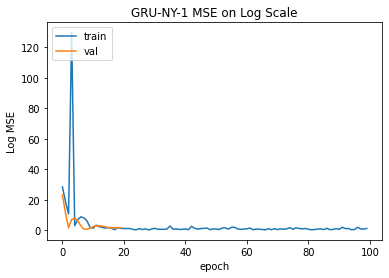

In [ ]:
print(min(hist1_ny.history['loss']), min(hist1_ny.history['val_loss']))
plt.plot(hist1_ny.history['loss'])#[:100])
plt.plot(hist1_la.history['val_loss'])#[:100])
plt.title('GRU-NY-1 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 29ms/step
gru1_ny: MSE:1.050776351548663


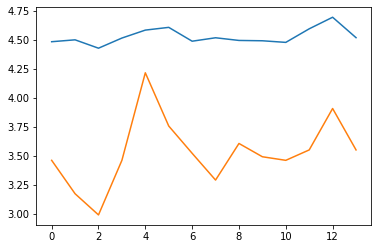

In [ ]:
gru1_ny_pred, gru1_ny_mse = predict(gru1_ny, Xtest_ny, Ytest_ny)
print('gru1_ny: MSE:{}'.format(gru1_ny_mse))

#### MD

In [ ]:
Xtr_md, Ytr_md = X_Y_window(pd.DataFrame(X[TRAIN_START:TRAIN_END, :, 2]), Y.iloc[TRAIN_START:TRAIN_END, 2], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_md, Yval_md = X_Y_window(pd.DataFrame(X[VAL_START:VAL_END, :, 2]), Y.iloc[VAL_START:VAL_END, 2], window_size=350)
Xtest_md, Ytest_md = X_Y_window(pd.DataFrame(X[TEST_START:TEST_END, :, 2]), Y.iloc[TEST_START:TEST_END, 2], window_size=350)

In [ ]:
gru1_md, hist1_md = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_md, Ytr_md, Xval_md, Yval_md, epoch=100)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 64)                14400     
                                                                 
 dense_42 (Dense)            (None, 8)                 520       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_43 (Dense)            (None, 1)                 9         
                                                                 
Total params: 14,929
Trainable params: 14,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 3s 1s/step - loss: 34.1950 - val_loss: 11.9685
Epoch 2/100
2/2 [==============================] - 0s 157ms/step - loss: 11.9639 - 

0.2607264220714569 4.182745456695557


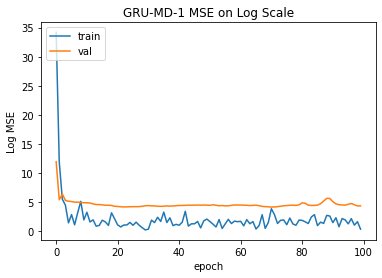

In [ ]:
print(min(hist1_md.history['loss']), min(hist1_md.history['val_loss']))
plt.plot(hist1_md.history['loss'])#[:100])
plt.plot(hist1_md.history['val_loss'])#[:100])
plt.title('GRU-MD-1 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 290ms/step
gru1_md: MSE:20.114813882608633


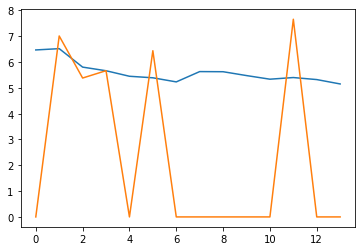

In [ ]:
gru1_md_pred, gru1_md_mse = predict(gru1_md, Xtest_md, Ytest_md)
print('gru1_md: MSE:{}'.format(gru1_md_mse))

#### SB

In [ ]:
Xtr_sb, Ytr_sb = X_Y_window(pd.DataFrame(X[TRAIN_START:TRAIN_END, :, 3]), Y.iloc[TRAIN_START:TRAIN_END, 3], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_sb, Yval_sb = X_Y_window(pd.DataFrame(X[VAL_START:VAL_END, :, 3]), Y.iloc[VAL_START:VAL_END, 3], window_size=350)
Xtest_sb, Ytest_sb = X_Y_window(pd.DataFrame(X[TEST_START:TEST_END, :, 3]), Y.iloc[TEST_START:TEST_END, 3], window_size=350)

In [ ]:
gru1_sb, hist1_sb = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_sb, Ytr_sb, Xval_sb, Yval_sb, epoch=100)

0.22201265394687653 0.9010485410690308


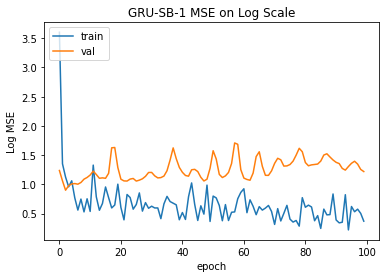

In [ ]:
print(min(hist1_sb.history['loss']), min(hist1_sb.history['val_loss']))
plt.plot(hist1_sb.history['loss'])#[:100])
plt.plot(hist1_sb.history['val_loss'])#[:100])
plt.title('GRU-SB-1 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 189ms/step
gru1_sb: MSE:1.2225991611573463


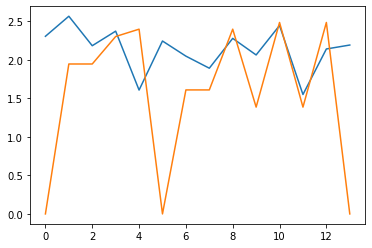

In [ ]:
gru1_sb_pred, gru1_sb_mse = predict(gru1_sb, Xtest_sb, Ytest_sb)
print('gru1_sb: MSE:{}'.format(gru1_sb_mse))

#### OR

In [ ]:
Xtr_or, Ytr_or = X_Y_window(pd.DataFrame(X[TRAIN_START:TRAIN_END, :, 4]), Y.iloc[TRAIN_START:TRAIN_END,4], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_or, Yval_or = X_Y_window(pd.DataFrame(X[VAL_START:VAL_END, :, 4]), Y.iloc[VAL_START:VAL_END, 4], window_size=350)
Xtest_or, Ytest_or = X_Y_window(pd.DataFrame(X[TEST_START:TEST_END, :, 4]), Y.iloc[TEST_START:TEST_END, 4], window_size=350)

In [ ]:
gru1_or, hist1_or = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_or, Ytr_or, Xval_or, Yval_or, epoch=100)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_21 (GRU)                (None, 64)                14400     
                                                                 
 dense_48 (Dense)            (None, 8)                 520       
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_49 (Dense)            (None, 1)                 9         
                                                                 
Total params: 14,929
Trainable params: 14,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 2s 345ms/step - loss: 14.1173 - val_loss: 3.6602
Epoch 2/100
2/2 [==============================] - 0s 124ms/step - loss: 6.3986 -

0.14942340552806854 0.08968649804592133


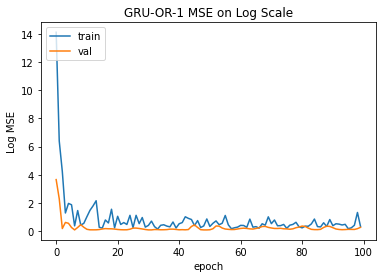

In [ ]:
print(min(hist1_or.history['loss']), min(hist1_or.history['val_loss']))
plt.plot(hist1_or.history['loss'])#[:100])
plt.plot(hist1_or.history['val_loss'])#[:100])
plt.title('GRU-OR-1 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 291ms/step
gru1_or: MSE:1.280980955018991


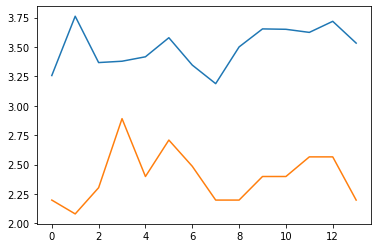

In [ ]:
gru1_or_pred, gru1_or_mse = predict(gru1_or, Xtest_or, Ytest_or)
print('gru1_or: MSE:{}'.format(gru1_or_mse))

#### HL

In [ ]:
Xtr_hl, Ytr_hl = X_Y_window(pd.DataFrame(X[TRAIN_START:TRAIN_END, :, 5]), Y.iloc[TRAIN_START:TRAIN_END, 5], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_hl, Yval_hl = X_Y_window(pd.DataFrame(X[VAL_START:VAL_END, :, 5]), Y.iloc[VAL_START:VAL_END, 5], window_size=350)
Xtest_hl, Ytest_hl = X_Y_window(pd.DataFrame(X[TEST_START:TEST_END, :, 5]), Y.iloc[TEST_START:TEST_END, 5], window_size=350)

In [ ]:
gru1_hl, hist1_hl = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_hl, Ytr_hl, Xval_hl, Yval_hl, epoch=100)

0.14408734440803528 1.0760308504104614


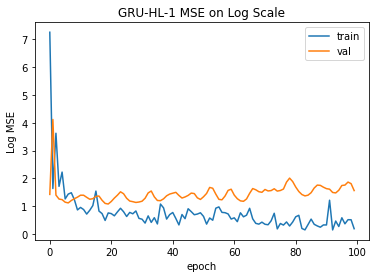

In [ ]:
print(min(hist1_hl.history['loss']), min(hist1_hl.history['val_loss']))
plt.plot(hist1_hl.history['loss'])#[:100])
plt.plot(hist1_hl.history['val_loss'])#[:100])
plt.title('GRU-HL-1 MSE on Log Scale')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

1/1 [==============================] - 1s 505ms/step
gru1_hl: MSE:5.932869418360178


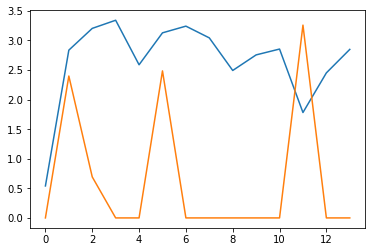

In [ ]:
gru1_hl_pred, gru1_hl_mse = predict(gru1_hl, Xtest_hl, Ytest_hl)
print('gru1_hl: MSE:{}'.format(gru1_hl_mse))

#### HL: Remove Parks + Transit (3, 4)

In [ ]:
X_HL = np.delete(X[TRAIN_START:TRAIN_END, :, 5], 4, axis=1)  # Remove 4th column (Transit)
X_HL = np.delete(X_HL, 3, axis=1)  # Remove 3rd column (Parks)
X_HL.shape

(364, 7)

In [ ]:
Xtr_hl, Ytr_hl = X_Y_window(pd.DataFrame(X_HL), Y.iloc[TRAIN_START:TRAIN_END, 5], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_hl, Yval_hl = X_Y_window(pd.DataFrame(X_HL), Y.iloc[VAL_START:VAL_END, 5], window_size=350)
Xtest_hl, Ytest_hl = X_Y_window(pd.DataFrame(X_HL), Y.iloc[TEST_START:TEST_END, 5], window_size=350)

In [ ]:
IN_DIM, OUT_DIM = (Xtr_hl.shape[1], Xtr_hl.shape[2]), 1
print(IN_DIM, OUT_DIM)

(350, 7) 1


In [ ]:
gru1_hl, hist1_hl = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_hl, Ytr_hl, Xval_hl, Yval_hl, epoch=100)

0.31630727648735046 0.7996158599853516


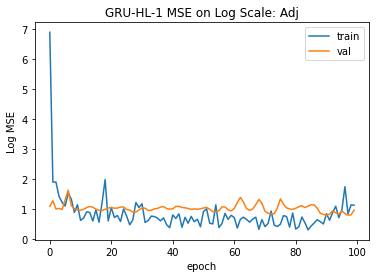

In [ ]:
print(min(hist1_hl.history['loss']), min(hist1_hl.history['val_loss']))
plt.plot(hist1_hl.history['loss'])#[:100])
plt.plot(hist1_hl.history['val_loss'])#[:100])
plt.title('GRU-HL-1 MSE on Log Scale: Adj')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 181ms/step
gru1_hl: MSE:3.2568173743900233


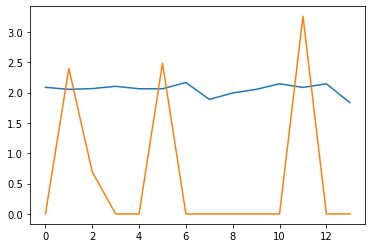

In [ ]:
gru1_hl_pred, gru1_hl_mse = predict(gru1_hl, Xtest_hl, Ytest_hl)
print('gru1_hl: MSE:{}'.format(gru1_hl_mse))

#### MD: Remove Parks + Transit (3, 4)

In [ ]:
X_MD = np.delete(X[TRAIN_START:TRAIN_END, :, 2], 4, axis=1)  # Remove 4th column (Transit)
X_MD = np.delete(X_MD, 3, axis=1)  # Remove 3rd column (Parks)
X_MD.shape

(364, 7)

In [ ]:
Xtr_md, Ytr_md = X_Y_window(pd.DataFrame(X_MD), Y.iloc[TRAIN_START:TRAIN_END, 2], window_size=350) #bc of missing dates, 1 year of data is captured with 350 days of cases
Xval_md, Yval_md = X_Y_window(pd.DataFrame(X_MD), Y.iloc[VAL_START:VAL_END, 2], window_size=350)
Xtest_md, Ytest_md = X_Y_window(pd.DataFrame(X_MD), Y.iloc[TEST_START:TEST_END, 2], window_size=350)

In [ ]:
IN_DIM, OUT_DIM = (Xtr_md.shape[1], Xtr_md.shape[2]), 1
print(IN_DIM, OUT_DIM)

(350, 7) 1


In [ ]:
gru1_md, hist1_md = fit(build_gru_1(IN_DIM, OUT_DIM), Xtr_md, Ytr_md, Xval_md, Yval_md, epoch=100)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_25 (GRU)                (None, 64)                14016     
                                                                 
 dense_56 (Dense)            (None, 8)                 520       
                                                                 
 dropout_18 (Dropout)        (None, 8)                 0         
                                                                 
 dense_57 (Dense)            (None, 1)                 9         
                                                                 
Total params: 14,545
Trainable params: 14,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 3s 388ms/step - loss: 37.6846 - val_loss: 9.4566
Epoch 2/100
2/2 [==============================] - 0s 152ms/step - loss: 9.0410 -

0.27289482951164246 4.419437408447266


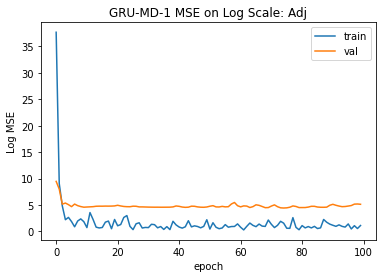

In [ ]:
print(min(hist1_md.history['loss']), min(hist1_md.history['val_loss']))
plt.plot(hist1_md.history['loss'])#[:100])
plt.plot(hist1_md.history['val_loss'])#[:100])
plt.title('GRU-MD-1 MSE on Log Scale: Adj')
plt.ylabel('Log MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 321ms/step
gru1_md: MSE:23.04017833462142


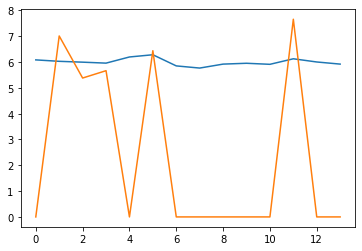

In [ ]:
gru1_md_pred, gru1_md_mse = predict(gru1_md, Xtest_md, Ytest_md)
print('gru1_md: MSE:{}'.format(gru1_md_mse))

### LSTM Autoencoder

In [ ]:
IN_DIM, OUT_DIM = (Xtr_agg.shape[1], Xtr_agg.shape[2]), 1
print(IN_DIM, OUT_DIM)

(350, 9) 1


In [ ]:
# def build_lstm_autoencoder(in_dim, out_dim, lr=1e-2):
#   model = Sequential()
#   model.add(LSTM(IN_DIM[0], dropout=0.2, recurrent_dropout=0.2, input_shape=in_dim, return_sequences=True))
#   model.add(LSTM(6, return_sequences=False))
#   model.add(RepeatVector(in_dim[0]))
#   model.add(LSTM(64, return_sequences=True))
#   model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#   model.add(TimeDistributed(Dense(64)))
#   model.add(Activation('relu'))
#   model.add(Dropout(0.1))
#   model.add(TimeDistributed(Dense(out_dim)))
#   model.compile(loss='mse', optimizer=Adam(learning_rate=lr))#, metrics=[MeanSquaredError()])
#   model.summary()
#   return model

In [ ]:
def build_lstm_autoencoder(in_dim, out_dim, lr=1e-2, activ='tanh'):
  encoder_decoder = Sequential()
  encoder_decoder.add(LSTM(IN_DIM[0], activation=activ, input_shape=IN_DIM, return_sequences=True))
  encoder_decoder.add(LSTM(6, activation=activ, return_sequences=True))
  encoder_decoder.add(LSTM(1, activation=activ))
  encoder_decoder.add(RepeatVector(IN_DIM[0]))
  encoder_decoder.add(LSTM(IN_DIM[0], activation=activ, return_sequences=True))
  encoder_decoder.add(LSTM(6, activation=activ, return_sequences=True))
  encoder_decoder.add(TimeDistributed(Dense(1)))
  encoder_decoder.summary()

  encoder_decoder.compile(loss='mse', optimizer=Adam(learning_rate=lr))
  return encoder_decoder

In [ ]:
encoder_decoder = build_lstm_autoencoder(IN_DIM, OUT_DIM)
encoder_decoder_history = encoder_decoder.fit(Xtr_agg, Xtr_agg, epochs=300, verbose=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 350, 350)          504000    
                                                                 
 lstm_12 (LSTM)              (None, 350, 6)            8568      
                                                                 
 lstm_13 (LSTM)              (None, 1)                 32        
                                                                 
 repeat_vector_2 (RepeatVect  (None, 350, 1)           0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 350, 350)          492800    
                                                                 
 lstm_15 (LSTM)              (None, 350, 6)            8568      
                                                     

In [ ]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

In [ ]:
train_encoded = encoder.predict(Xtr_agg)
validation_encoded = encoder.predict(Xval_agg)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

1/1 [==============================] - 0s 180ms/step
Encoded time-series shape (14, 1)
Encoded time-series sample [0.15016547]


In [ ]:
Xtr_agg.shape

(14, 350, 9)

In [ ]:
IN_DIM

(350, 9)

In [ ]:
mlp_model = Sequential()
# model = Sequential()
# model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=1, return_sequences=True))
mlp_model.add(Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=1))
mlp_model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(Dense(1))
mlp_model.summary()
mlp_model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                64        
                                                                 
 dense_34 (Dense)            (None, 8)                 264       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


'date', 'retail_and_recreation', 'grocery_and_pharmacy', 'residential',
'transit_stations', 'parks', 'workplaces', 'dayofweek', 'month', 'year_mod'

In [ ]:
X_train_encoded = train_encoded
Y_train_encoded = Ytr_agg
X_valid_encoded = validation_encoded
Y_valid_encoded = Yval_agg

In [ ]:
mlp_history = mlp_model.fit(X_train_encoded, Y_train_encoded, \
                            epochs=300,\
                            validation_data=(X_valid_encoded, Y_valid_encoded), verbose=1)

In [ ]:
test_encoded = encoder.predict(X_test_reshaped)
mlp_test_pred = mlp_model.predict(X_test_encoded)

NameError: ignored

### Hide

In [ ]:
# model = Sequential()
# model.add(Dense(1024, input_shape=in_dim))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))

# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))

# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(Dense(1))

# sgd = SGD(lr=0.01, nesterov=True);
# #rms = RMSprop()
# #model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
# model.compile(loss='mean_absolute_error', optimizer=sgd)
# # model.fit(X_train, Y_train, batch_size=32, nb_epoch=3, verbose=1, validation_data=(X_test,Y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=4)] )

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:

# TRAIN_START = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2020, 6, 1)].index[0]
# TRAIN_END = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2021, 6, 1)].index[0] # Exclude this end
# VAL_START = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2020, 6, 15)].index[0] 
# VAL_END = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2021, 6, 15)].index[0] 
# TEST_START = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2021, 6, 15)].index[0] 
# TEST_END = X_dict[locs[0]][X_dict[locs[0]]['date'] == datetime(2022, 6, 14)].index[0] +1
# ONE_YEAR = dates.index(datetime(2021, 6, 1)) - dates.index(datetime(2020, 6, 1))

Create sliding windows